In [13]:
import numpy as np
import networkx as nx
from scipy.optimize import minimize

from qiskit import *
from qiskit import Aer
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram

In [14]:
backend = Aer.get_backend('qasm_simulator')
backend.shots = 1024*500

Set inital state of measured spin:

In [15]:
phi = 0

Define circuit based on Fig. 2b in paper:

In [16]:
def create_qaoa_cir(G, theta):
    N_qubits = len(G.nodes())
    p = len(theta)//2
    qc = QuantumCircuit(N_qubits)
    
    gamma = theta[:p]
    beta = theta[p:]
    
    for i in range((N_qubits-1)//2):
        qc.h(i)
    
    qc.ry(phi, (N_qubits-1)//2)
    # qc.h(N_qubits//2)
    
    for i in range((N_qubits+1)//2, N_qubits):
        qc.h(i)
    
    for irep in range(p):
        for pair in list(G.edges()):
            qc.rzz(-2*gamma[irep], pair[0], pair[1])
            
        #for i in range(N_qubits):
         #   qc.rx(2*beta[irep], i)
        
        for i in range((N_qubits-1)//2):
            qc.rx(2*beta[irep], i)
        for i in range((N_qubits+1)//2, N_qubits):
            qc.rx(2*beta[irep], i)
        
    qc.measure_all()
    
    return qc

Define objective function:

In [17]:
def Ising_obj(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] == x[j]:
            obj -= 1
        else:
            obj +=1
    return obj

Calculating expectation value of circuit:

In [18]:
def compute_expectation(counts, G):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = Ising_obj(bitstring, G)
        avg += obj * count
        sum_count += count
    return avg/sum_count

Calculating parametrized circuit expectation value:

In [19]:
def get_expectation(G, theta, shots=1024):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_cir(G, theta)
        counts = backend.run(qc, seed_simulator=10, nshots=1024).result().get_counts()
    
        return compute_expectation(counts, G)
    
    return execute_circ

Results plot:

In [20]:
def plot_counts(x):
    qc_res = create_qaoa_cir(G, x)
    counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
    
    return qc_res.draw('mpl'), plot_histogram(counts)

Generate nearest Ising Hamiltonian with a 1D chain of 7 qubits: 

In [21]:
G = nx.Graph()
N=7
#nearest interaction
for i in range(N-1):
    G.add_edge(i, i+1, weight=-1)
for i in range(N):
    G.add_node(i, weight=0)

Initialize parameters of 3 layers with 6 parameters as:

In [22]:
theta = [1, 1, 1, 1, 1, 1]

Finding optimized parameters with variational method:

In [23]:
exp = get_expectation(G, theta)
res = minimize(exp, theta, method="COBYLA")

In [24]:
res

     fun: -5.974609375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 113
  status: 1
 success: True
       x: array([2.39278374, 2.32628394, 2.34594002, 0.76757343, 0.75836103,
       0.74384174])

Output the optimized circuit output state for measured spin input state as |0>:

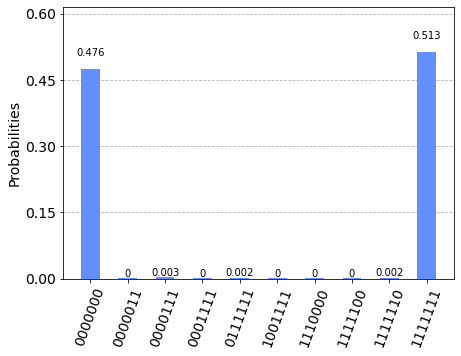

In [25]:
P = plot_counts(res.x)
P[1]

Fix the optimized parameters in circuit and change the input state of measured spin:

In [25]:
phi = np.pi/4
theta = [2.40756694, 2.37257408, 2.34787417, 0.79040416, 0.78994118,
       0.73654257]

In [26]:
exp = get_expectation(G, theta)
res = minimize(exp, theta, method="COBYLA")

In [27]:
res

     fun: -5.9921875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 48
  status: 1
 success: True
       x: array([2.37962072, 2.36791103, 2.34563802, 0.78150532, 0.79568363,
       0.75388623])

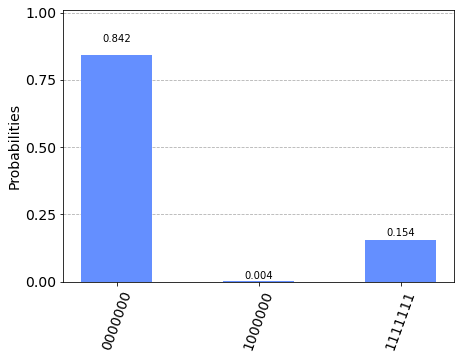

In [28]:
P = plot_counts(res.x)
P[1]

In [29]:
phi = np.pi/2
theta = [2.40756694, 2.37257408, 2.34787417, 0.79040416, 0.78994118,
       0.73654257]

In [30]:
exp = get_expectation(G, theta)
res = minimize(exp, theta, method="COBYLA")

In [31]:
res

     fun: -5.994140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 50
  status: 1
 success: True
       x: array([2.38536158, 2.35516428, 2.36270432, 0.79060672, 0.7813355 ,
       0.75285169])

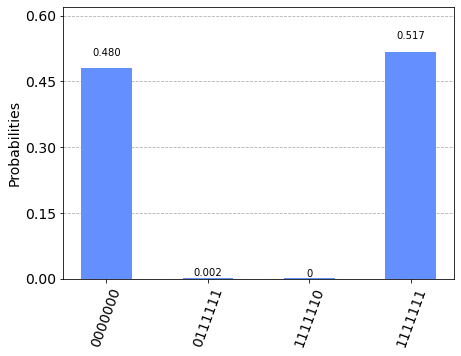

In [32]:
P = plot_counts(res.x)
P[1]

In [33]:
phi = np.pi
theta = [2.40756694, 2.37257408, 2.34787417, 0.79040416, 0.78994118,
       0.73654257]

In [34]:
exp = get_expectation(G, theta)
res = minimize(exp, theta, method="COBYLA")

In [35]:
res

     fun: -5.984375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 56
  status: 1
 success: True
       x: array([2.3947153 , 2.37586459, 2.34913808, 0.79322872, 0.79567406,
       0.75606524])

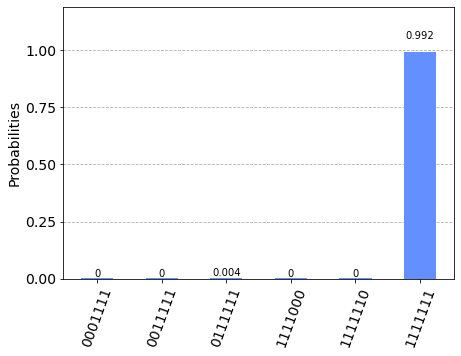

In [36]:
P = plot_counts(res.x)
P[1]